In [23]:
import re
import gym
import gym_unicycle
import time 
import numpy as np
import csv
import os
from os import path
from pathlib import Path
import matplotlib.pyplot as plt



import environment_wrapper as UniEnv


#env = gym.make('unicycle-v0')
#env = DummyVecEnv([lambda: env])



In [2]:
env = UniEnv.UnicycleEnv()
model_name = 'ppo2_all_equal_reward+counter_largerandom_inital_pos_newfilter.pkl'
#path to DL models
model_path = '/Users/Maria/Documents/skolinn/Chalmers/thesis/Unicycle_Project/Evaluation/Simulation/DL_models/'
model = np.load(model_path + model_name)


/Users/Maria/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [30]:
#initial position to simulate:
init_pitch = 5
init_roll = 5
init_state = np.array([0,0,0,0,init_roll*np.pi/180,init_pitch*np.pi/180])
max_timesteps = 1500
input_filter = True
lambda_value = 0.9

In [31]:
entire_data = model[1]

pi_fc0_w = entire_data[0]
pi_fc0_b = entire_data[1]

pi_fc1_w = entire_data[4]
pi_fc1_b = entire_data[5]

pi_w = entire_data[10]
pi_b = entire_data[11]

pi_log = entire_data[12]
#print(pi_log)

def predict_pi_network(obs):
    out1 = np.tanh(pi_fc0_w.transpose()@obs + pi_fc0_b)
    out2 = np.tanh(pi_fc1_w.transpose()@out1 + pi_fc1_b)
    out3 = pi_w.transpose()@out2 + pi_b
    out3 = np.clip(out3, -12, 12)
    return out3.reshape(1,2)

def weighted_average(old_value, new_value, lambda_value, weight_input):
    if old_value is None:
        old_value = 0
        
    weight_input = lambda_value * weight_input + 1
    filtered_output = (1 - 1/weight_input) * old_value + (1/weight_input) * new_value

    
    return weight_input, filtered_output
def predict_LQR(obs):
    out = -K_LQR@obs[0:6]
    return out.reshape(1,2)
 

In [32]:
obs = env.init_states(init_state)
u_w = 0
u_d = 0
dalpha_w = 0
dalpha_d = 0
dphi = 0
dtheta = 0
phi = 0
theta = 0
t = 0
u_old = np.zeros(2)
w1 = 0
w2 = 0

while True:
    t = t + 1
    action = predict_pi_network(obs)
    
    if input_filter:
        w1,action[0,0] = weighted_average(action[0,0],u_old[0], lambda_value, w1)
        w2, action[0,1] = weighted_average(action[0,1],u_old[1], lambda_value, w2)
        u_old[0] = action[0,0]
        u_old[1] = action[0,1]
    
    obs, rewards, dones, info = env.step(action[0])
    u_w = np.append(u_w, action[0][0])
    u_d = np.append(u_d, action[0][1])
    dalpha_w = np.append(dalpha_w, obs[0])
    dalpha_d = np.append(dalpha_d, obs[1])
    dphi = np.append(dphi, obs[2])
    dtheta = np.append(dtheta, obs[3])
    phi = np.append(phi, obs[4])
    theta = np.append(theta, obs[5])

    if dones:
        print("Episode finished after {} timesteps".format(t+1))
        t = 0
        break
        
    if t == max_timesteps:
        print("Episode finished after {} timesteps".format(t+1))
        t = 0
        break


init_states
Episode finished after 1501 timesteps


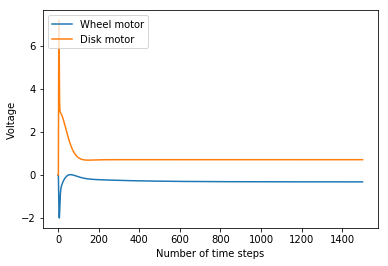

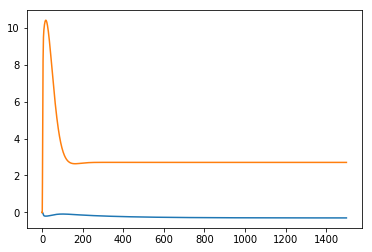

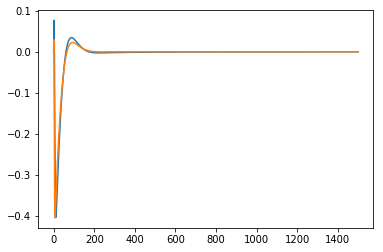

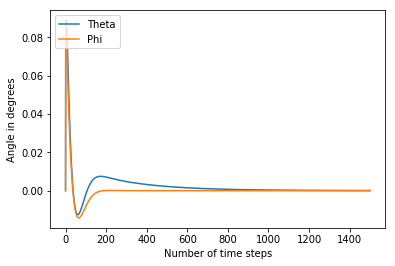

In [33]:
plt.plot(u_w,label='Wheel motor')
plt.plot(u_d, label='Disk motor')
plt.xlabel('Number of time steps')
plt.ylabel('Voltage')
plt.legend(loc='upper left')
plt.show()

plt.plot(dalpha_w)
plt.plot(dalpha_d)
plt.show()

plt.plot(dtheta)
plt.plot(dphi)
plt.show()

plt.plot(theta, label='Theta')
plt.plot(phi, label='Phi')
plt.xlabel('Number of time steps')
plt.ylabel('Angle in degrees')
plt.legend(loc='upper left')
plt.show()

In [34]:
#Save to a matlab readable file
log_for_plotting = 'initial_angle_from_' + model_name + '.csv'

my_file = Path(log_for_plotting)
if my_file.is_file():
    print('Older version overwritten')
    os.remove(log_for_plotting)


Older version overwritten


In [35]:
with open(log_for_plotting, 'w') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerows([dalpha_w,dalpha_d,dtheta,dphi,theta, phi, u_w, u_d])
